In [32]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [34]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [35]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [36]:
tf.keras.backend.clear_session()

In [37]:
subject = 'Goiás - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [38]:
data = pd.read_csv('2003_mo_model_input_GO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - Consumo de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,56.459960,97.447,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,56.789152,97.256,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,57.140263,101.442,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,57.649192,98.217,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,58.213295,112.540,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


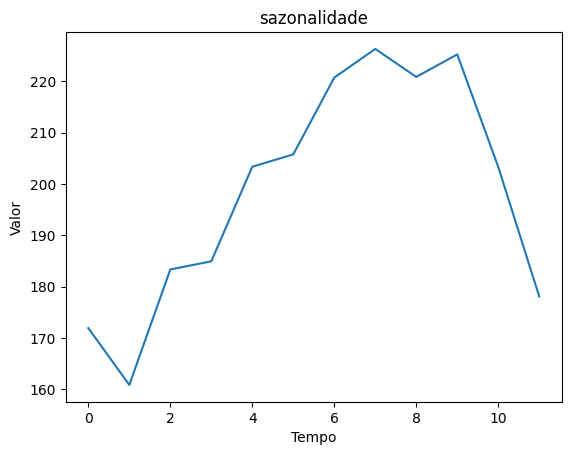

,sazonalidade
sazonalidade,
0,171.893313
1,160.821351
2,183.321109
3,184.916194
4,203.346145
5,205.750017
6,220.720017
7,226.305536
8,220.849793


In [39]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [40]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Goiás - Consumo de Cimento (t)
0,2003-1,56.459960,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,171.893313,97.447
1,2003-2,56.789152,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,160.821351,97.256
2,2003-3,57.140263,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,183.321109,101.442
3,2003-4,57.649192,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,184.916194,98.217
4,2003-5,58.213295,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,203.346145,112.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.346145,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.750017,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.720017,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.305536,NaN


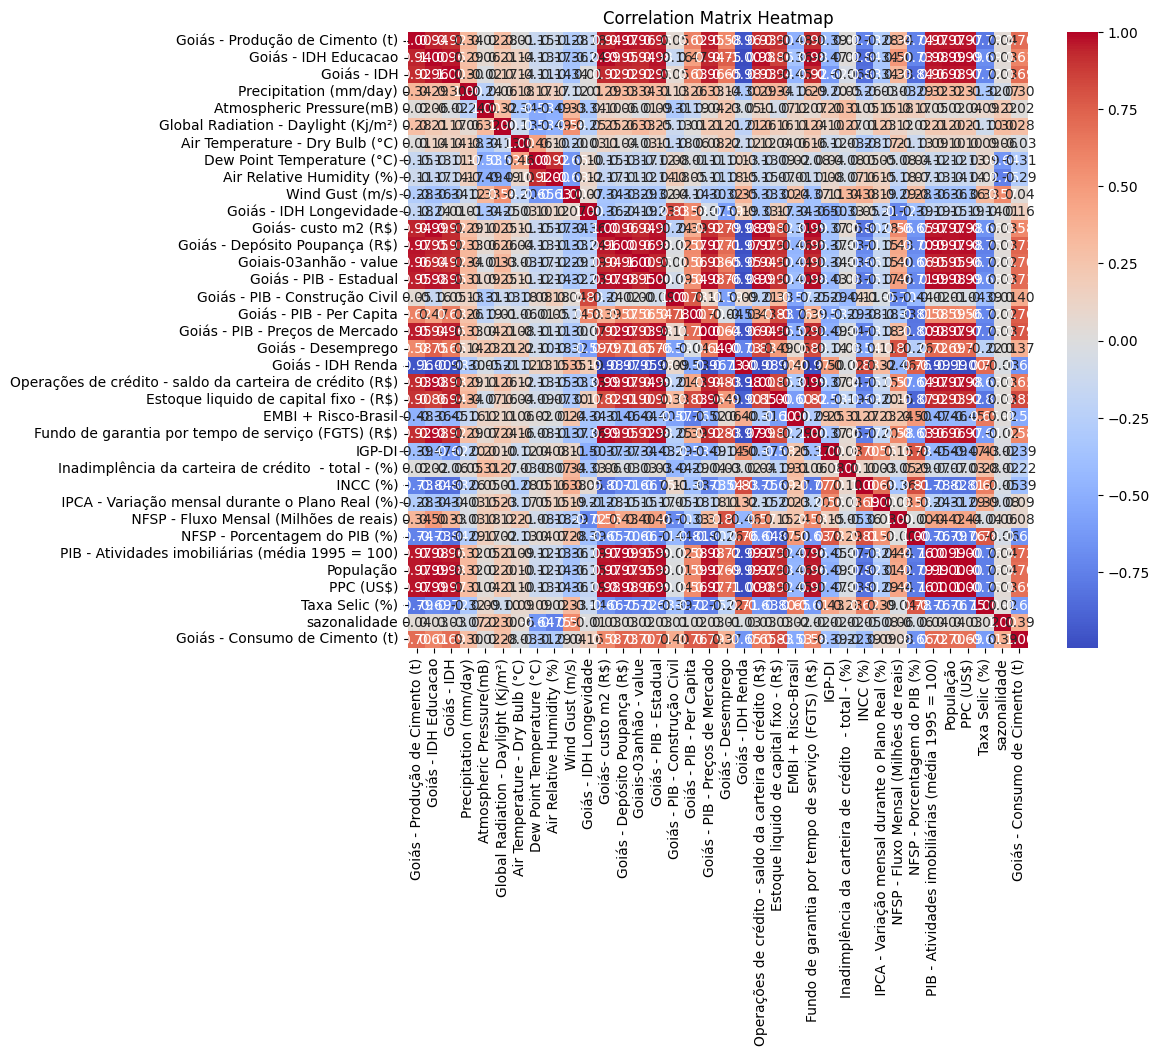

In [41]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [42]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [43]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.656649,-1.800946,-2.298583,0.258583,-0.163024,0.952850,0.368966,1.185364,1.275432,-0.492693,-1.983949,-1.477026,-1.547841,-0.950106,-1.718818,-1.724379,-2.510500,-2.091868,-0.400818,1.889667,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.248173
1,-1.644539,-1.779586,-2.259040,-0.109783,0.154829,0.923860,-0.183839,0.918794,1.172452,-0.295685,-1.904643,-1.458842,-1.537759,-0.970613,-1.700304,-1.668988,-2.459954,-2.059753,-0.411374,1.865969,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.763473
2,-1.631624,-1.758226,-2.219497,-0.489401,0.497547,0.530848,-0.942839,0.430785,0.911516,-0.176554,-1.825337,-1.441847,-1.527678,-0.999751,-1.681790,-1.613597,-2.409407,-2.027637,-0.421930,1.842271,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.716313
3,-1.612902,-1.736866,-2.179955,-0.617995,1.075602,0.622672,-1.685236,-0.332805,0.310923,0.422562,-1.746030,-1.425730,-1.517596,-1.025491,-1.663277,-1.558206,-2.358860,-1.995522,-0.432487,1.818573,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.642076
4,-1.592151,-1.715506,-2.140412,-1.432536,1.458513,0.718788,-2.139903,-1.082280,-0.397031,0.932583,-1.666724,-1.408431,-1.507515,-1.058403,-1.644763,-1.502815,-2.308314,-1.963406,-0.443043,1.794875,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.215672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.639330,1.493364,0.726172,-0.235206,0.321177,-0.097413,0.278906,-0.826130,-1.027305,-0.903913,-2.202746,1.734506,1.343432,1.221276,1.118822,-1.173185,-0.446937,0.837128,0.999503,-1.346286,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.284225
188,1.677410,1.495000,0.682578,-0.149901,-0.165111,-0.040632,0.659967,-0.316346,-0.602530,-1.079101,-2.300209,1.754804,1.358753,1.236987,1.111624,-1.156891,-0.447051,0.832077,1.003711,-1.350162,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.030309
189,1.732332,1.496636,0.638983,-0.186849,-0.231341,-0.064420,0.861358,0.274186,-0.068507,-1.160337,-2.397672,1.776595,1.374073,1.252847,1.104427,-1.140596,-0.447166,0.827027,1.007918,-1.354037,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.234611
190,1.763870,1.498272,0.595389,-0.169383,-0.327536,0.018875,0.883410,0.548970,0.254095,-1.303024,-2.495135,1.802277,1.389393,1.276241,1.097229,-1.124301,-0.447280,0.821977,1.012126,-1.357913,1.370978,0.332791,

In [44]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0       93.660
1       85.349
2      116.097
3      120.197
4      122.728
        ...   
256        NaN
257        NaN
258        NaN
259        NaN
260        NaN
Name: Goiás - Consumo de Cimento (t), Length: 261, dtype: float64

In [45]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.656649,-1.800946,-2.298583,0.258583,-0.163024,0.952850,0.368966,1.185364,1.275432,-0.492693,-1.983949,-1.477026,-1.547841,-0.950106,-1.718818,-1.724379,-2.510500,-2.091868,-0.400818,1.889667,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.248173
1,-1.644539,-1.779586,-2.259040,-0.109783,0.154829,0.923860,-0.183839,0.918794,1.172452,-0.295685,-1.904643,-1.458842,-1.537759,-0.970613,-1.700304,-1.668988,-2.459954,-2.059753,-0.411374,1.865969,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.763473
2,-1.631624,-1.758226,-2.219497,-0.489401,0.497547,0.530848,-0.942839,0.430785,0.911516,-0.176554,-1.825337,-1.441847,-1.527678,-0.999751,-1.681790,-1.613597,-2.409407,-2.027637,-0.421930,1.842271,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.716313
3,-1.612902,-1.736866,-2.179955,-0.617995,1.075602,0.622672,-1.685236,-0.332805,0.310923,0.422562,-1.746030,-1.425730,-1.517596,-1.025491,-1.663277,-1.558206,-2.358860,-1.995522,-0.432487,1.818573,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.642076
4,-1.592151,-1.715506,-2.140412,-1.432536,1.458513,0.718788,-2.139903,-1.082280,-0.397031,0.932583,-1.666724,-1.408431,-1.507515,-1.058403,-1.644763,-1.502815,-2.308314,-1.963406,-0.443043,1.794875,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.215672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.623245,1.369411,1.561651,-0.257374,0.131316,0.557838,1.381481,0.752880,0.275146,-0.906175,0.262580,1.147748,0.741968,0.944351,1.175698,-1.121085,-0.108013,0.955652,1.757990,-1.335765,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.763473
158,0.644558,1.371559,1.540971,-0.383476,0.644844,0.280901,0.653347,0.290362,0.009062,-0.715165,0.191684,1.169222,0.762122,0.952621,1.178649,-1.137848,-0.116498,0.956673,1.696610,-1.337255,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,-0.716313
159,0.663382,1.373708,1.520292,-0.103699,1.060363,0.338726,0.008734,-0.452155,-0.599619,-0.488086,0.120788,1.191107,0.782277,0.960982,1.181601,-1.154611,-0.124984,0.957693,1.635230,-1.338745,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-0.642076
160,0.670170,1.375856,1.499612,0.154067,1.443344,0.049279,-0.452584,-0.985366,-0.998607,-0.390703,0.049891,1.212156,0.802432,0.969363,1.184552,-1.171374,-0.133469,0.958714,1.573850,-1.340235,1.306664,0.785801,1.017171,1.240

In [46]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       93.660
1       85.349
2      116.097
3      120.197
4      122.728
        ...   
157    146.310
158    191.374
159    164.318
160    211.049
161    198.789
Name: Goiás - Consumo de Cimento (t), Length: 162, dtype: float64

In [47]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [48]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [49]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.798828,0.490123,0.605338,-0.354087,0.921039,0.208461,-0.755457,-1.034540,-0.922670,0.288222,-0.078111,0.498821,1.135213,0.673675,0.830615,0.695340,0.936426,0.971320,0.568035,-0.649831,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,1.024269
127,0.774031,0.503985,0.608897,-0.125102,0.355082,0.482703,-0.151240,-0.740810,-0.820505,0.195956,-0.128552,0.519319,1.152844,0.687412,0.848214,0.652086,0.905979,0.976868,0.664626,-0.646029,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.284225
128,0.731137,0.517847,0.612457,0.720628,-0.283367,0.307633,0.252355,-0.087802,-0.222596,0.096964,-0.178994,0.539930,1.170476,0.706891,0.865813,0.608833,0.875531,0.982416,0.761218,-0.642227,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,1.030309
129,0.695886,0.531709,0.616016,0.497599,-0.569474,0.499457,0.305085,0.377084,0.288584,-0.478819,-0.229435,0.560682,1.188107,0.722784,0.883412,0.565579,0.845084,0.987963,0.857809,-0.638425,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.234611
130,0.655420,0.545571,0.619576,0.525779,-0.835999,0.599951,0.311461,0.643926,0.611816,-0.661613,-0.279876,0.581445,1.205739,0.738712,0.901011,0.522326,0.814636,0.993511,0.954400,-0.634623,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.214144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.639330,1.493364,0.726172,-0.235206,0.321177,-0.097413,0.278906,-0.826130,-1.027305,-0.903913,-2.202746,1.734506,1.343432,1.221276,1.118822,-1.173185,-0.446937,0.837128,0.999503,-1.346286,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.284225
188,1.677410,1.495000,0.682578,-0.149901,-0.165111,-0.040632,0.659967,-0.316346,-0.602530,-1.079101,-2.300209,1.754804,1.358753,1.236987,1.111624,-1.156891,-0.447051,0.832077,1.003711,-1.350162,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.030309
189,1.732332,1.496636,0.638983,-0.186849,-0.231341,-0.064420,0.861358,0.274186,-0.068507,-1.160337,-2.397672,1.776595,1.374073,1.252847,1.104427,-1.140596,-0.447166,0.827027,1.007918,-1.354037,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.234611
190,1.763870,1.498272,0.595389,-0.169383,-0.327536,0.018875,0.883410,0.548970,0.254095,-1.303024,-2.495135,1.802277,1.389393,1.276241,1.097229,-1.124301,-0.447280,0.821977,1.012126,-1.357913,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,

In [50]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [51]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [52]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [53]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(20)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_val_loss = min(history.history['val_loss'][500:])
        current_loss = history.history['loss'][history.history['val_loss'].index(current_val_loss)]
        decision_value = (current_val_loss*current_val_loss)*current_loss 
        print(f"val_loss: {current_val_loss}; loss={current_loss} => decision_value={decision_value}")

        if decision_value < best_loss:
            best_loss = decision_value
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [54]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1434254082, 3753399204, 2940284102, 2377932931, 3837224538, 3168772927, 1656035209, 3304227995, 350972357, 3263369396, 2920015690, 1325127919, 2072494021, 2710121897, 3799077892, 1670952374, 1484152515, 1620346351, 373432020, 1904669371]


Step: 0 ___________________________________________
val_loss: 466.94146728515625; loss=97.19359588623047 => decision_value=21191540.935524534
winner_seed: 1434254082


Step: 1 ___________________________________________
val_loss: 298.9239196777344; loss=319.1744384765625 => decision_value=28519994.650998905


Step: 2 ___________________________________________
val_loss: 342.5750732421875; loss=75.51477813720703 => decision_value=8862239.228829468
winner_seed: 2940284102


Step: 3 ___________________________________________
val_loss: 473.9495544433594; loss=28.996631622314453 => decision_value=6513460.5920051215
winner_seed: 2377932931


Step: 4 ___________________________________________
val_loss: 482.27447509765625; loss=132.22080993652344 => decis

In [55]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 123ms/step - loss: 38498.7930 - val_loss: 2189.4739
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 2000.5209 - val_loss: 1982.6721
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 2039.6993 - val_loss: 1980.9657
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 2299.5444 - val_loss: 2420.0520
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 2355.3940 - val_loss: 2183.2451
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 2508.9854 - val_loss: 1969.3613
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 1983.4563 - val_loss: 1944.6802
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 2450.5652 - val_loss: 1969.2604
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 2289.5935 - val_loss: 2465.4114
Epoch 10/10000
4/4 [========================

4/4 [==============================] - 0s 10ms/step - loss: 300.2184 - val_loss: 696.6353
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 381.9961 - val_loss: 452.6239
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 310.9301 - val_loss: 407.5622
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 360.0045 - val_loss: 408.0703
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 269.5322 - val_loss: 339.8547
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 227.4985 - val_loss: 394.0552
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 276.1317 - val_loss: 545.9333
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 472.6401 - val_loss: 454.0639
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 253.6020 - val_loss: 421.5653
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss

Epoch 156/10000
4/4 [==============================] - 0s 11ms/step - loss: 208.4123 - val_loss: 680.6096
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 327.4996 - val_loss: 568.7541
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 219.0558 - val_loss: 568.7234
Epoch 159/10000
4/4 [==============================] - 0s 12ms/step - loss: 165.3714 - val_loss: 494.3564
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 247.6842 - val_loss: 588.2749
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 198.7661 - val_loss: 456.1637
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 172.8668 - val_loss: 436.9252
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 187.3064 - val_loss: 467.3585
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 160.4905 - val_loss: 428.6756
Epoch 165/10000
4/4 [==========================

4/4 [==============================] - 0s 10ms/step - loss: 130.6873 - val_loss: 482.4561
Epoch 234/10000
4/4 [==============================] - 0s 10ms/step - loss: 132.8106 - val_loss: 569.0012
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 127.1699 - val_loss: 521.3679
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 208.7007 - val_loss: 520.5244
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 140.4050 - val_loss: 436.1571
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 147.9931 - val_loss: 384.3744
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 117.8068 - val_loss: 436.6336
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 167.8062 - val_loss: 466.5280
Epoch 241/10000
4/4 [==============================] - 0s 9ms/step - loss: 141.4995 - val_loss: 515.9028
Epoch 242/10000
4/4 [==============================] - 0s 10ms/st

Epoch 311/10000
4/4 [==============================] - 0s 10ms/step - loss: 123.5417 - val_loss: 541.8162
Epoch 312/10000
4/4 [==============================] - 0s 10ms/step - loss: 120.3235 - val_loss: 503.4399
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 105.0814 - val_loss: 545.1473
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.9205 - val_loss: 533.3005
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 128.2688 - val_loss: 541.0302
Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 97.6994 - val_loss: 519.8994
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 114.4695 - val_loss: 527.5237
Epoch 318/10000
4/4 [==============================] - 0s 10ms/step - loss: 127.1805 - val_loss: 455.9493
Epoch 319/10000
4/4 [==============================] - 0s 10ms/step - loss: 107.4648 - val_loss: 483.9525
Epoch 320/10000
4/4 [===========================

4/4 [==============================] - 0s 10ms/step - loss: 84.3891 - val_loss: 480.1945
Epoch 389/10000
4/4 [==============================] - 0s 10ms/step - loss: 86.4805 - val_loss: 515.9694
Epoch 390/10000
4/4 [==============================] - 0s 9ms/step - loss: 133.8481 - val_loss: 527.6304
Epoch 391/10000
4/4 [==============================] - 0s 10ms/step - loss: 96.2395 - val_loss: 501.4565
Epoch 392/10000
4/4 [==============================] - 0s 10ms/step - loss: 113.1049 - val_loss: 543.7509
Epoch 393/10000
4/4 [==============================] - 0s 10ms/step - loss: 107.2059 - val_loss: 475.7466
Epoch 394/10000
4/4 [==============================] - 0s 9ms/step - loss: 83.0763 - val_loss: 515.2777
Epoch 395/10000
4/4 [==============================] - 0s 11ms/step - loss: 123.0782 - val_loss: 527.2601
Epoch 396/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.3421 - val_loss: 563.4875
Epoch 397/10000
4/4 [==============================] - 0s 10ms/step -

4/4 [==============================] - 0s 10ms/step - loss: 80.9722 - val_loss: 480.2225
Epoch 467/10000
4/4 [==============================] - 0s 10ms/step - loss: 74.9644 - val_loss: 494.9450
Epoch 468/10000
4/4 [==============================] - 0s 10ms/step - loss: 82.3172 - val_loss: 620.5441
Epoch 469/10000
4/4 [==============================] - 0s 10ms/step - loss: 117.4637 - val_loss: 541.0776
Epoch 470/10000
4/4 [==============================] - 0s 10ms/step - loss: 74.0976 - val_loss: 523.9128
Epoch 471/10000
4/4 [==============================] - 0s 10ms/step - loss: 64.7643 - val_loss: 506.4396
Epoch 472/10000
4/4 [==============================] - 0s 10ms/step - loss: 62.0984 - val_loss: 554.0834
Epoch 473/10000
4/4 [==============================] - 0s 10ms/step - loss: 66.3404 - val_loss: 523.1379
Epoch 474/10000
4/4 [==============================] - 0s 10ms/step - loss: 68.5408 - val_loss: 510.9429
Epoch 475/10000
4/4 [==============================] - 0s 9ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 70.5879 - val_loss: 524.7899
Epoch 545/10000
4/4 [==============================] - 0s 8ms/step - loss: 50.4991 - val_loss: 519.4707
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.5202 - val_loss: 495.6718
Epoch 547/10000
4/4 [==============================] - 0s 10ms/step - loss: 61.9444 - val_loss: 503.7215
Epoch 548/10000
4/4 [==============================] - 0s 10ms/step - loss: 71.1643 - val_loss: 518.6672
Epoch 549/10000
4/4 [==============================] - 0s 9ms/step - loss: 58.5956 - val_loss: 551.8978
Epoch 550/10000
4/4 [==============================] - 0s 10ms/step - loss: 87.3676 - val_loss: 532.0455
Epoch 551/10000
4/4 [==============================] - 0s 10ms/step - loss: 71.3231 - val_loss: 527.6804
Epoch 552/10000
4/4 [==============================] - 0s 10ms/step - loss: 71.6341 - val_loss: 529.2655
Epoch 553/10000
4/4 [==============================] - 0s 10ms/step - loss

4/4 [==============================] - 0s 10ms/step - loss: 90.4787 - val_loss: 497.6072
Epoch 623/10000
4/4 [==============================] - 0s 10ms/step - loss: 85.9275 - val_loss: 498.8032
Epoch 624/10000
4/4 [==============================] - 0s 10ms/step - loss: 60.3229 - val_loss: 520.1862
Epoch 625/10000
4/4 [==============================] - 0s 10ms/step - loss: 58.3978 - val_loss: 523.5263
Epoch 626/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.2827 - val_loss: 501.7433
Epoch 627/10000
4/4 [==============================] - 0s 10ms/step - loss: 55.0454 - val_loss: 557.8787
Epoch 628/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.7761 - val_loss: 497.7798
Epoch 629/10000
4/4 [==============================] - 0s 10ms/step - loss: 57.2907 - val_loss: 506.7954
Epoch 630/10000
4/4 [==============================] - 0s 10ms/step - loss: 51.7955 - val_loss: 585.8982
Epoch 631/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 64.7105 - val_loss: 519.5074
Epoch 701/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.1410 - val_loss: 506.7918
Epoch 702/10000
4/4 [==============================] - 0s 10ms/step - loss: 65.3834 - val_loss: 498.2872
Epoch 703/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.8457 - val_loss: 476.4317
Epoch 704/10000
4/4 [==============================] - 0s 10ms/step - loss: 64.2081 - val_loss: 493.4105
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.7410 - val_loss: 478.7955
Epoch 706/10000
4/4 [==============================] - 0s 10ms/step - loss: 53.4912 - val_loss: 465.0904
Epoch 707/10000
4/4 [==============================] - 0s 10ms/step - loss: 45.7613 - val_loss: 493.4097
Epoch 708/10000
4/4 [==============================] - 0s 10ms/step - loss: 45.6714 - val_loss: 482.6733
Epoch 709/10000
4/4 [==============================] - 0s 10ms/step - loss:

4/4 [==============================] - 0s 10ms/step - loss: 76.2810 - val_loss: 558.0372
Epoch 779/10000
4/4 [==============================] - 0s 12ms/step - loss: 58.8508 - val_loss: 508.1797
Epoch 780/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.8241 - val_loss: 495.7315
Epoch 781/10000
4/4 [==============================] - 0s 10ms/step - loss: 62.4884 - val_loss: 477.8551
Epoch 782/10000
4/4 [==============================] - 0s 11ms/step - loss: 63.4494 - val_loss: 507.2213
Epoch 783/10000
4/4 [==============================] - 0s 11ms/step - loss: 59.4486 - val_loss: 523.4226
Epoch 784/10000
4/4 [==============================] - 0s 10ms/step - loss: 61.0293 - val_loss: 537.9271
Epoch 785/10000
4/4 [==============================] - 0s 11ms/step - loss: 60.2670 - val_loss: 527.0546
Epoch 786/10000
4/4 [==============================] - 0s 10ms/step - loss: 50.8891 - val_loss: 550.5067
Epoch 787/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 49.0271 - val_loss: 510.1327
Epoch 857/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.8593 - val_loss: 504.7976
Epoch 858/10000
4/4 [==============================] - 0s 11ms/step - loss: 44.8336 - val_loss: 519.0132
Epoch 859/10000
4/4 [==============================] - 0s 11ms/step - loss: 43.8042 - val_loss: 499.5836
Epoch 860/10000
4/4 [==============================] - 0s 10ms/step - loss: 46.2369 - val_loss: 501.8518
Epoch 861/10000
4/4 [==============================] - 0s 12ms/step - loss: 41.8374 - val_loss: 517.1479
Epoch 862/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.8093 - val_loss: 510.7797
Epoch 863/10000
4/4 [==============================] - 0s 11ms/step - loss: 51.4053 - val_loss: 507.5198
Epoch 864/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.7988 - val_loss: 513.0025
Epoch 865/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 39.2834 - val_loss: 473.2728
Epoch 935/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.3435 - val_loss: 478.2715
Epoch 936/10000
4/4 [==============================] - 0s 9ms/step - loss: 48.4326 - val_loss: 516.0078
Epoch 937/10000
4/4 [==============================] - 0s 10ms/step - loss: 45.3562 - val_loss: 506.1125
Epoch 938/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.8107 - val_loss: 516.3408
Epoch 939/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.1325 - val_loss: 510.2277
Epoch 940/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.1265 - val_loss: 501.9525
Epoch 941/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.7406 - val_loss: 515.0837
Epoch 942/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.4226 - val_loss: 509.1452
Epoch 943/10000
4/4 [==============================] - 0s 9ms/step - loss

4/4 [==============================] - 0s 9ms/step - loss: 40.0203 - val_loss: 480.1825
Epoch 1013/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.7434 - val_loss: 519.5527
Epoch 1014/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.5951 - val_loss: 526.8295
Epoch 1015/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.4380 - val_loss: 506.6747
Epoch 1016/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.0104 - val_loss: 511.9296
Epoch 1017/10000
4/4 [==============================] - 0s 10ms/step - loss: 45.1254 - val_loss: 508.6161
Epoch 1018/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.6370 - val_loss: 463.9144
Epoch 1019/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.0800 - val_loss: 470.3625
Epoch 1020/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.9557 - val_loss: 488.3969
Epoch 1021/10000
4/4 [==============================] - 0s 10ms/st

4/4 [==============================] - 0s 11ms/step - loss: 48.3993 - val_loss: 474.0956
Epoch 1090/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.5281 - val_loss: 510.0539
Epoch 1091/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.2381 - val_loss: 475.0931
Epoch 1092/10000
4/4 [==============================] - 0s 12ms/step - loss: 33.7647 - val_loss: 482.8734
Epoch 1093/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.6338 - val_loss: 483.8724
Epoch 1094/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.5558 - val_loss: 491.5189
Epoch 1095/10000
4/4 [==============================] - 0s 11ms/step - loss: 84.5531 - val_loss: 492.3521
Epoch 1096/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.8461 - val_loss: 475.9428
Epoch 1097/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.4529 - val_loss: 490.8234
Epoch 1098/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 10ms/step - loss: 42.2072 - val_loss: 458.1858
Epoch 1167/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.2074 - val_loss: 448.3610
Epoch 1168/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.6088 - val_loss: 463.3255
Epoch 1169/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.5709 - val_loss: 466.5272
Epoch 1170/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.6827 - val_loss: 469.9152
Epoch 1171/10000
4/4 [==============================] - 0s 9ms/step - loss: 39.1894 - val_loss: 466.4147
Epoch 1172/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.6304 - val_loss: 485.8417
Epoch 1173/10000
4/4 [==============================] - 0s 10ms/step - loss: 46.4234 - val_loss: 487.8130
Epoch 1174/10000
4/4 [==============================] - 0s 10ms/step - loss: 52.5865 - val_loss: 466.2772
Epoch 1175/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 10ms/step - loss: 27.4684 - val_loss: 492.1317
Epoch 1244/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.5410 - val_loss: 497.0526
Epoch 1245/10000
4/4 [==============================] - 0s 10ms/step - loss: 58.2138 - val_loss: 497.3900
Epoch 1246/10000
4/4 [==============================] - 0s 15ms/step - loss: 33.9619 - val_loss: 484.5963
Epoch 1247/10000
4/4 [==============================] - 0s 10ms/step - loss: 46.9254 - val_loss: 481.6947
Epoch 1248/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.9093 - val_loss: 494.4843
Epoch 1249/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.0519 - val_loss: 503.4949
Epoch 1250/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.4956 - val_loss: 496.0087
Epoch 1251/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.2055 - val_loss: 470.3929
Epoch 1252/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 9ms/step - loss: 27.6995 - val_loss: 480.0831
Epoch 1321/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.1738 - val_loss: 450.1829
Epoch 1322/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.3792 - val_loss: 457.6955
Epoch 1323/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.5077 - val_loss: 449.0130
Epoch 1324/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.7807 - val_loss: 461.1047
Epoch 1325/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.3088 - val_loss: 494.0095
Epoch 1326/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.1591 - val_loss: 452.3645
Epoch 1327/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.7982 - val_loss: 473.2421
Epoch 1328/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.2953 - val_loss: 457.0954
Epoch 1329/10000
4/4 [==============================] - 0s 10ms/ste

4/4 [==============================] - 0s 11ms/step - loss: 23.3091 - val_loss: 481.3317
Epoch 1398/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.6518 - val_loss: 486.3493
Epoch 1399/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.0174 - val_loss: 478.5379
Epoch 1400/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.6905 - val_loss: 465.2241
Epoch 1401/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.0374 - val_loss: 473.4320
Epoch 1402/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.4684 - val_loss: 490.3549
Epoch 1403/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.5348 - val_loss: 487.3032
Epoch 1404/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.4613 - val_loss: 488.3346
Epoch 1405/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.4269 - val_loss: 486.4452
Epoch 1406/10000
4/4 [==============================] - 0s 10ms/ste

4/4 [==============================] - 0s 10ms/step - loss: 24.0502 - val_loss: 446.1068
Epoch 1475/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.9428 - val_loss: 446.1261
Epoch 1476/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.9988 - val_loss: 465.2448
Epoch 1477/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.3368 - val_loss: 475.1758
Epoch 1478/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.3492 - val_loss: 457.2943
Epoch 1479/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.5392 - val_loss: 465.7459
Epoch 1480/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.6747 - val_loss: 459.2145
Epoch 1481/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.1018 - val_loss: 461.6383
Epoch 1482/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.9215 - val_loss: 463.0963
Epoch 1483/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 8ms/step - loss: 28.8295 - val_loss: 515.7058
Epoch 1552/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.5069 - val_loss: 494.4171
Epoch 1553/10000
4/4 [==============================] - 0s 8ms/step - loss: 34.4114 - val_loss: 487.1921
Epoch 1554/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.4695 - val_loss: 513.8040
Epoch 1555/10000
4/4 [==============================] - 0s 8ms/step - loss: 32.8844 - val_loss: 498.0378
Epoch 1556/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.2512 - val_loss: 485.5032
Epoch 1557/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.5526 - val_loss: 520.2124
Epoch 1558/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.2788 - val_loss: 504.9240
Epoch 1559/10000
4/4 [==============================] - 0s 8ms/step - loss: 27.8601 - val_loss: 491.8666
Epoch 1560/10000
4/4 [==============================] - 0s 9ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 141.0959 - val_loss: 464.5322
Epoch 1629/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.9966 - val_loss: 460.9511
Epoch 1630/10000
4/4 [==============================] - 0s 10ms/step - loss: 113.3817 - val_loss: 468.2602
Epoch 1631/10000
4/4 [==============================] - 0s 10ms/step - loss: 137.3004 - val_loss: 422.3463
Epoch 1632/10000
4/4 [==============================] - 0s 10ms/step - loss: 93.3663 - val_loss: 496.6967
Epoch 1633/10000
4/4 [==============================] - 0s 10ms/step - loss: 114.5661 - val_loss: 462.5747
Epoch 1634/10000
4/4 [==============================] - 0s 10ms/step - loss: 142.3757 - val_loss: 426.0404
Epoch 1635/10000
4/4 [==============================] - 0s 10ms/step - loss: 112.9833 - val_loss: 446.4061
Epoch 1636/10000
4/4 [==============================] - 0s 10ms/step - loss: 101.7992 - val_loss: 470.5519
Epoch 1637/10000
4/4 [==============================] -

4/4 [==============================] - 0s 10ms/step - loss: 87.6363 - val_loss: 421.5828
Epoch 1706/10000
4/4 [==============================] - 0s 9ms/step - loss: 61.4085 - val_loss: 421.1146
Epoch 1707/10000
4/4 [==============================] - 0s 10ms/step - loss: 62.3713 - val_loss: 420.3231
Epoch 1708/10000
4/4 [==============================] - 0s 10ms/step - loss: 72.9534 - val_loss: 427.3646
Epoch 1709/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.2082 - val_loss: 393.5357
Epoch 1710/10000
4/4 [==============================] - 0s 10ms/step - loss: 48.4429 - val_loss: 405.2268
Epoch 1711/10000
4/4 [==============================] - 0s 10ms/step - loss: 58.3624 - val_loss: 395.6564
Epoch 1712/10000
4/4 [==============================] - 0s 9ms/step - loss: 84.8597 - val_loss: 440.6056
Epoch 1713/10000
4/4 [==============================] - 0s 10ms/step - loss: 107.5203 - val_loss: 425.2567
Epoch 1714/10000
4/4 [==============================] - 0s 10ms/

Epoch 1783/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.3588 - val_loss: 420.9865
Epoch 1784/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.6852 - val_loss: 429.9999
Epoch 1785/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.3634 - val_loss: 490.3656
Epoch 1786/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.4683 - val_loss: 496.8245
Epoch 1787/10000
4/4 [==============================] - 0s 10ms/step - loss: 58.3406 - val_loss: 447.2136
Epoch 1788/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.8417 - val_loss: 472.1061
Epoch 1789/10000
4/4 [==============================] - 0s 9ms/step - loss: 73.0906 - val_loss: 480.4736
Epoch 1790/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.2181 - val_loss: 476.9306
Epoch 1791/10000
4/4 [==============================] - 0s 10ms/step - loss: 78.0994 - val_loss: 475.9665
Epoch 1792/10000
4/4 [============================

4/4 [==============================] - 0s 10ms/step - loss: 30.5371 - val_loss: 467.2886
Epoch 1861/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.6893 - val_loss: 486.0871
Epoch 1862/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.3026 - val_loss: 462.4618
Epoch 1863/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.4372 - val_loss: 463.3062
Epoch 1864/10000
4/4 [==============================] - 0s 10ms/step - loss: 48.2892 - val_loss: 447.0182
Epoch 1865/10000
4/4 [==============================] - 0s 10ms/step - loss: 46.1322 - val_loss: 474.6693
Epoch 1866/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.0274 - val_loss: 473.0112
Epoch 1867/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.3679 - val_loss: 449.0377
Epoch 1868/10000
4/4 [==============================] - 0s 10ms/step - loss: 55.4732 - val_loss: 457.5417
Epoch 1869/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 10ms/step - loss: 29.7698 - val_loss: 484.9100
Epoch 1938/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.0309 - val_loss: 498.5384
Epoch 1939/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.6491 - val_loss: 560.4915
Epoch 1940/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.1832 - val_loss: 504.5362
Epoch 1941/10000
4/4 [==============================] - 0s 10ms/step - loss: 55.7778 - val_loss: 511.0986
Epoch 1942/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.3455 - val_loss: 497.4100
Epoch 1943/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.0402 - val_loss: 480.1932
Epoch 1944/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.8324 - val_loss: 509.0854
Epoch 1945/10000
4/4 [==============================] - 0s 10ms/step - loss: 45.4627 - val_loss: 485.9152
Epoch 1946/10000
4/4 [==============================] - 0s 9ms/ste

4/4 [==============================] - 0s 9ms/step - loss: 43.8768 - val_loss: 429.5072
Epoch 2015/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.3516 - val_loss: 430.7257
Epoch 2016/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.4800 - val_loss: 413.1800
Epoch 2017/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.2694 - val_loss: 424.4491
Epoch 2018/10000
4/4 [==============================] - 0s 10ms/step - loss: 43.3857 - val_loss: 415.0860
Epoch 2019/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.1973 - val_loss: 424.5269
Epoch 2020/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.3679 - val_loss: 392.4066
Epoch 2021/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.3969 - val_loss: 399.8508
Epoch 2022/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.7825 - val_loss: 391.5621
Epoch 2023/10000
4/4 [==============================] - 0s 10ms/ste

4/4 [==============================] - 0s 10ms/step - loss: 38.1452 - val_loss: 468.4231
Epoch 2092/10000
4/4 [==============================] - 0s 10ms/step - loss: 50.8691 - val_loss: 414.5518
Epoch 2093/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.8578 - val_loss: 421.1622
Epoch 2094/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.1436 - val_loss: 438.1750
Epoch 2095/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.7395 - val_loss: 444.6200
Epoch 2096/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.8034 - val_loss: 434.9972
Epoch 2097/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.1185 - val_loss: 452.0385
Epoch 2098/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.4631 - val_loss: 448.4214
Epoch 2099/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.2470 - val_loss: 446.9939
Epoch 2100/10000
4/4 [==============================] - 0s 10ms/st

4/4 [==============================] - 0s 12ms/step - loss: 32.8119 - val_loss: 430.4359
Epoch 2169/10000
4/4 [==============================] - 0s 11ms/step - loss: 42.8742 - val_loss: 462.0309
Epoch 2170/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.8722 - val_loss: 442.8694
Epoch 2171/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.6104 - val_loss: 452.6248
Epoch 2172/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.9638 - val_loss: 460.6667
Epoch 2173/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.8795 - val_loss: 478.8924
Epoch 2174/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.2949 - val_loss: 476.2609
Epoch 2175/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.1975 - val_loss: 450.6839
Epoch 2176/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.7411 - val_loss: 450.3802
Epoch 2177/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 19.2999 - val_loss: 466.0068
Epoch 2246/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.2587 - val_loss: 475.9736
Epoch 2247/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.5812 - val_loss: 504.3567
Epoch 2248/10000
4/4 [==============================] - 0s 10ms/step - loss: 46.1509 - val_loss: 456.4301
Epoch 2249/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.1695 - val_loss: 443.8008
Epoch 2250/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.6894 - val_loss: 452.4627
Epoch 2251/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.5508 - val_loss: 451.0733
Epoch 2252/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.5287 - val_loss: 473.6092
Epoch 2253/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.8758 - val_loss: 478.8627
Epoch 2254/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 35.9943 - val_loss: 455.8292
Epoch 2323/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.9411 - val_loss: 450.8331
Epoch 2324/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.0217 - val_loss: 462.8890
Epoch 2325/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.1857 - val_loss: 456.2485
Epoch 2326/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.2885 - val_loss: 446.4001
Epoch 2327/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.2440 - val_loss: 447.6202
Epoch 2328/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.8302 - val_loss: 467.8661
Epoch 2329/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.4242 - val_loss: 447.3364
Epoch 2330/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.1500 - val_loss: 440.2401
Epoch 2331/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 23.7350 - val_loss: 448.1256
Epoch 2400/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.1032 - val_loss: 459.8492
Epoch 2401/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.2996 - val_loss: 469.1854
Epoch 2402/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.7209 - val_loss: 472.9547
Epoch 2403/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.8564 - val_loss: 478.8648
Epoch 2404/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.4255 - val_loss: 527.8406
Epoch 2405/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.6080 - val_loss: 446.5617
Epoch 2406/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.1550 - val_loss: 453.1479
Epoch 2407/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.0548 - val_loss: 459.7418
Epoch 2408/10000
4/4 [==============================] - 0s 10ms/st

4/4 [==============================] - 0s 9ms/step - loss: 18.5821 - val_loss: 431.7320
Epoch 2477/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.7398 - val_loss: 437.8673
Epoch 2478/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.1002 - val_loss: 428.4918
Epoch 2479/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.2372 - val_loss: 421.4575
Epoch 2480/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.2391 - val_loss: 437.2213
Epoch 2481/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.7980 - val_loss: 452.2395
Epoch 2482/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.1451 - val_loss: 465.7665
Epoch 2483/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.2466 - val_loss: 469.5156
Epoch 2484/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.1239 - val_loss: 449.4797
Epoch 2485/10000
4/4 [==============================] - 0s 11ms/s

4/4 [==============================] - 0s 9ms/step - loss: 19.4140 - val_loss: 442.1381
Epoch 2554/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.5468 - val_loss: 451.3192
Epoch 2555/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.9285 - val_loss: 438.2758
Epoch 2556/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.0900 - val_loss: 440.4300
Epoch 2557/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.2120 - val_loss: 461.8189
Epoch 2558/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.5542 - val_loss: 446.7888
Epoch 2559/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.8855 - val_loss: 441.2635
Epoch 2560/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.9846 - val_loss: 433.2623
Epoch 2561/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.7457 - val_loss: 431.7338
Epoch 2562/10000
4/4 [==============================] - 0s 10ms/step

In [56]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [57]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 20ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,216.317398,214.529968,212.359955,208.933105,194.046188,189.372314,187.16983,183.547394,186.269287,191.702087,204.724228,210.342499,211.25473,206.396133,191.67421,192.975082,186.696075,186.713684,184.247513,181.803421,182.719406,185.901993,187.479126,190.825317,192.723404,182.131683,188.604477,190.261475,186.299927,170.832184
Target,205.551,230.558,209.621,210.984,189.889,143.721,176.275,152.632,177.876,181.384,160.12,236.951,206.557,224.27,213.871,211.066,182.899,159.002,178.918,161.936,173.792,176.627,207.991,185.784,234.176,226.996,218.141,234.939,199.619,168.797
Error,10.766403,16.02803,2.738953,2.050888,4.157181,45.651321,10.894836,30.91539,8.39328,10.318085,44.604233,26.608505,4.697723,17.873871,22.196793,18.090912,3.797073,27.711685,5.329514,19.867416,8.927399,9.274994,20.511871,5.041321,41.452591,44.864319,29.53653,44.677521,13.319077,2.035187


In [58]:
display(mae)
display(mape)

18.411097

0.096386746

In [59]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [60]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined